<h1 align = "center">Univariate LSTM Network</h1>

---


**Objective:** Create a *bare neural network* LSTM model for univariate time series data and check the functionalities and capabilities. Note the model developed here are just for informational purpose and the actual model is to be developed and trained in cloud. The notebook also serves as a reference to all the *beautiful* custom-built user-defined functionalities available.

## Prediction of Future Sequence

A LSTM network can be developed to predict future sequence of a given length (defined as **`n_forecast`**) by - (I) creating a output layer (generally `Dense`) of `length == n_forecast`, as described [here](https://stackoverflow.com/a/69912334/6623589), or (II) create a function that takes previous input and keep on iterating for `n_forecast` as in [this video](https://youtu.be/UbvkhuqVqUI?t=1026). In this notebook, both the approach is tried however the accuracy metric and performance comparison are to be added later. The `n_lookup` and `n_forecast` can be explained as in:

![prediction-sequence](https://i.stack.imgur.com/YXwMJ.png)

where, $T$ is the lookback period defined as **`n_lookup`** throught the code, and $H$ is the forecast period defined as **`n_forecast`**.

### Lookback Period (`n_lookup`)

The day's considered while model training. Based on *previous analysis* it is observed that past fifteen (15) days data has an impact on the bid execution day (i.e. $D_{t_{1}}$) thus for model training we can cosider a sequence of shape `(-1, 15 * 96, 1)` where `96` is the number of blocks for a day. Thus, `n_lookup` will take a sequence data comprising of $D_{t_{-16}}$ to $D_{t_{-2}}$ while sitting on $D_{t_{-1}}$ to predict.

### Forecast Period (`n_forecast`)

Sitting on $D_{t_{-1}}$ to predict, the bids are to be placed on $D_{t_{0}}$ for $D_{t_{1}}$ thus we need `2 * 96 = 192` worth sequence of data. While some data may already available, this needs more clarifications and thus total data of $D_{t_{0}}$ is neglected for all markets.

In [1]:
# use the code release version for tracking and code modifications. use the
# CHANGELOG.md file to keep track of version features, and/or release notes.
# the version file is avaiable at project root directory, check the
# global configuration setting for root directory information.
# the file is already read and is available as `__version__`
__version__ = open("../VERSION", "rt").read() # bump codecov
print(f"Current Code Version: {__version__}") # TODO : author, contact

Current Code Version: 


## Code Imports

A code must be written such that it is always _production ready_. The conventional guidelines provided under [**PEP8**](https://peps.python.org/pep-0008/#imports) defines the conventional or syntactically useful ways of defining and/or manipulating functions. Necessar guidelines w.r.t. code imports are mentioned below, and basic libraries and import settings are defined.

 1. Imports should be on separate lines,
 2. Import order should be:
    * standard library/modules,
    * related third party imports,
    * local application/user defined imports
 3. Wildcard import (`*`) should be avoided, else specifically tagged with **`# noqa: F403`** as per `flake8` or **`# pylint: disable=unused-import`** as per `pylint`
 4. Avoid using relative imports; use explicit imports instead.

In [2]:
import os   # miscellaneous os interfaces
import sys  # configuring python runtime environment
import time # library for time manipulation, and logging

In [3]:
# use `datetime` to control and preceive the environment
# in addition `pandas` also provides date time functionalities
import datetime as dt

In [4]:
from copy import deepcopy      # dataframe is mutable
# from tqdm import tqdm as TQ    # progress bar for loops
# from uuid import uuid4 as UUID # unique identifier for objs

### Data Analysis and AI/ML Libraries

Import of data analysis and AI/ML libraries required at different intersections. Check settings and configurations [here](https://gitlab.com/ZenithClown/computer-configurations-and-setups) and code snippets [here](https://gitlab.com/ZenithClown/computer-configurations-and-setups/-/tree/master/template/snippets/vscode) for understanding settings that is used in this notebook. The code uses `matplotlib.styles` which is a custom `.mplstyle` file recognised by the `matplotlib` downlodable from [this link](https://gitlab.com/ZenithClown/computer-configurations-and-setups/-/tree/master/settings/python/matplotlib).

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%precision 3
%matplotlib inline
sns.set_style('whitegrid');
plt.style.use('default-style');

pd.set_option('display.max_rows', 50) # max. rows to show
pd.set_option('display.max_columns', 15) # max. cols to show
np.set_printoptions(precision = 3, threshold = 15) # set np options
pd.options.display.float_format = '{:,.3f}'.format # float precisions

In [6]:
# for rmse, use `squared = False` : https://stackoverflow.com/a/18623635/
from sklearn.metrics import (
    mean_squared_error as MSE,
    mean_absolute_error as MAE
)

In [7]:
import tensorflow as tf
print(f"Tensorflow Version: {tf.__version__}", end = "\n\n") # required >= 2.8

# check physical devices, and gpu compute capability (if available)
if len(tf.config.list_physical_devices(device_type = "GPU")):
    # https://stackoverflow.com/q/38009682/6623589
    # https://stackoverflow.com/a/59179238/6623589
    print("GPU Computing Available.", end = " ")
    
    # experimentally, get the gpu details and computation power
    # https://www.tensorflow.org/api_docs/python/tf/config/experimental/get_device_details
    devices = tf.config.list_physical_devices(device_type = "GPU")[0] # first
    details = tf.config.experimental.get_device_details(devices) # only first
    details.get('device_name', 'compute_capability')
    print(f"EXPERIMENTAL : {details}")
else:
    print("GPU Computing Not Available. If `GPU` is present, check configuration. Detected Devices:")
    print("  > ", tf.config.list_physical_devices())

Tensorflow Version: 2.9.0

GPU Computing Available. EXPERIMENTAL : {'device_name': 'NVIDIA GeForce GTX 1650', 'compute_capability': (7, 5)}


### User Defined Function(s)

It is recommended that any UDFs are defined outside the scope of the *jupyter notebook* such that development/editing of function can be done more practically. As per *programming guidelines* as [`src`](https://fileinfo.com/extension/src) file/directory is beneficial in code development and/or production release. However, *jupyter notebook* requires *kernel restart* if any imported code file is changed in disc, for this frequently changing functions can be defined in this section.

**Getting Started** with **`PYTHONPATH`**

One must know what are [Environment Variable](https://medium.com/chingu/an-introduction-to-environment-variables-and-how-to-use-them-f602f66d15fa) and how to call/use them in your choice of programming language. Note that an environment variable is *case sensitive* in all operating systems (except windows, since DOS is not case sensitive). Generally, we can access environment variables from terminal/shell/command prompt as:

```shell
# macOS/*nix
echo $VARNAME

# windows
echo %VARNAME%
```

Once you've setup your system with [`PYTHONPATH`](https://bic-berkeley.github.io/psych-214-fall-2016/using_pythonpath.html) as per [*python documentation*](https://docs.python.org/3/using/cmdline.html#envvar-PYTHONPATH) is an important directory where any `import` statements looks for based on their order of importance. If a source code/module is not available check necessary environment variables and/or ask the administrator for the source files. For testing purpose, the module boasts the use of `src`, `utils` and `config` directories. However, these directories are available at `ROOT` level, and thus using `sys.path.append()` to add directories while importing.

In [8]:
# append `src` and sub-modules to call additional files these directory are
# project specific and not to be added under environment or $PATH variable
sys.path.append(os.path.join("..", "src")) # parent/source files directory
sys.path.append(os.path.join("..", "src", "agents")) # agents for reinforcement modelling
sys.path.append(os.path.join("..", "src", "engine")) # derivative engines for model control
sys.path.append(os.path.join("..", "src", "models")) # actual models for decision making tools

In [9]:
# also append the `utilities` directory for additional helpful codes
sys.path.append(os.path.join("..", "utilities"))

In [10]:
from plotting import * # noqd: F403 # pylint: disable=unused-import

from trainer import base
from lstm import BareLSTM
from featuring import CreateSequence
from scaler import UnivariateRangedScaler

## Global Argument(s)

The global arguments are *notebook* specific, however they may also be extended to external libraries and functions on import. The *boilerplate* provides a basic ML directory structure which contains a directory for `data` and a separate directory for `output`. In addition, a separate directory (`data/processed`) is created to save processed dataset such that preprocessing can be avoided.

In [11]:
ROOT = ".." # the document root is one level up, that contains all code structure
DATA = os.path.join(ROOT, "data") # the directory contains all data files, subdirectory (if any) can also be used/defined

# processed data directory can be used, such that preprocessing steps is not
# required to run again-and-again each time on kernel restart
PROCESSED_DATA = os.path.join(DATA, "processed")

In [12]:
# long projects can be overwhelming, and keeping track of files, outputs and
# saved models can be intriguing! to help this out, `today` can be used. for
# instance output can be stored at `output/<today>/` etc.
# `today` is so configured that it permits windows/*.nix file/directory names
today = dt.datetime.strftime(dt.datetime.strptime(time.ctime(), "%a %b %d %H:%M:%S %Y"), "%a, %b %d %Y")
print(f"Code Execution Started on: {today}") # only date, name of the sub-directory

Code Execution Started on: Tue, Feb 21 2023


In [13]:
OUTPUT_DIR = os.path.join(ROOT, "output")

## Read Input File(s)

A typical machine learning project revolves around six important stages (as available in [Amazon ML Life Cycle Documentation](https://docs.aws.amazon.com/wellarchitected/latest/machine-learning-lens/well-architected-machine-learning-lifecycle.html)). The notebook boilerplate is provided to address two pillars:

 1. **Data Processing:** An integral part of any machine learning project, which is the most time consuming step! A brief introduction and best practices is available [here](https://towardsdatascience.com/introduction-to-data-preprocessing-in-machine-learning-a9fa83a5dc9d).
 2. **Model Development:** From understanding to deployment, this section address development (training, validating and testing) of an machine learning model.

![ML Life Cycle](https://docs.aws.amazon.com/wellarchitected/latest/machine-learning-lens/images/ml-lifecycle.png)

In [24]:
market_snapshot = pd.read_pickle(os.path.join(PROCESSED_DATA, "df_consolidated_2012-04-01_2022-12-31.pickle"))
market_snapshot.sample()

,EffectiveDate,year,month,day,BlockID,PurchaseBid,SellBid,MCV,MCP,scaled(MCP)
59538,2013-12-13,2013,12,13,19,"3,949.500","6,789.100","3,593.100","1,999.470",1.095


### Exploratory Data Analysis (EDA)

Extensive EDA has been *previously* discussed, however though different patterns were available the same does not give a conclusive story that defines the **MCP (Market Clearing Price)** of a given block. In addition, reasons for sudden shocks is abrupt and is not fully explained from the *market snapshot* data. Keeping the core logic at minimum, the following section analyze the data and gives some aggregated results.

In [12]:
# create a monthly aggregated statistical summary sheet
monthly_statistics_ = market_snapshot.drop(columns = ["EffectiveDate", "day", "BlockID"]) \
    .groupby(by = ["year", "month"]) \
    .agg([
        "min",
        lambda x : np.quantile(x, 0.05),
        lambda x : np.quantile(x, 0.25),
        lambda x : np.quantile(x, 0.50),
        lambda x : np.quantile(x, 0.75),
        lambda x : np.quantile(x, 0.95),
        "max"
    ]) \
    .rename(columns = {
        "<lambda_0>" : "q05",
        "<lambda_1>" : "q25",
        "<lambda_2>" : "q50",
        "<lambda_3>" : "q75",
        "<lambda_4>" : "q95",
    })

monthly_statistics_.sample()

PurchaseBid                                                     \
                   min       q05       q25       q50       q75        q95   
year month                                                                  
2019 7       3,342.500 4,795.750 5,993.975 7,362.550 9,443.675 12,413.350   

                       ...       MCP                                          \
                  max  ...       min       q05       q25       q50       q75   
year month             ...                                                     
2019 7     15,141.400  ... 1,047.320 2,013.540 2,589.068 2,989.635 3,675.770   

                                
                 q95       max  
year month                      
2019 7     6,500.142 9,294.100  

[1 rows x 28 columns]

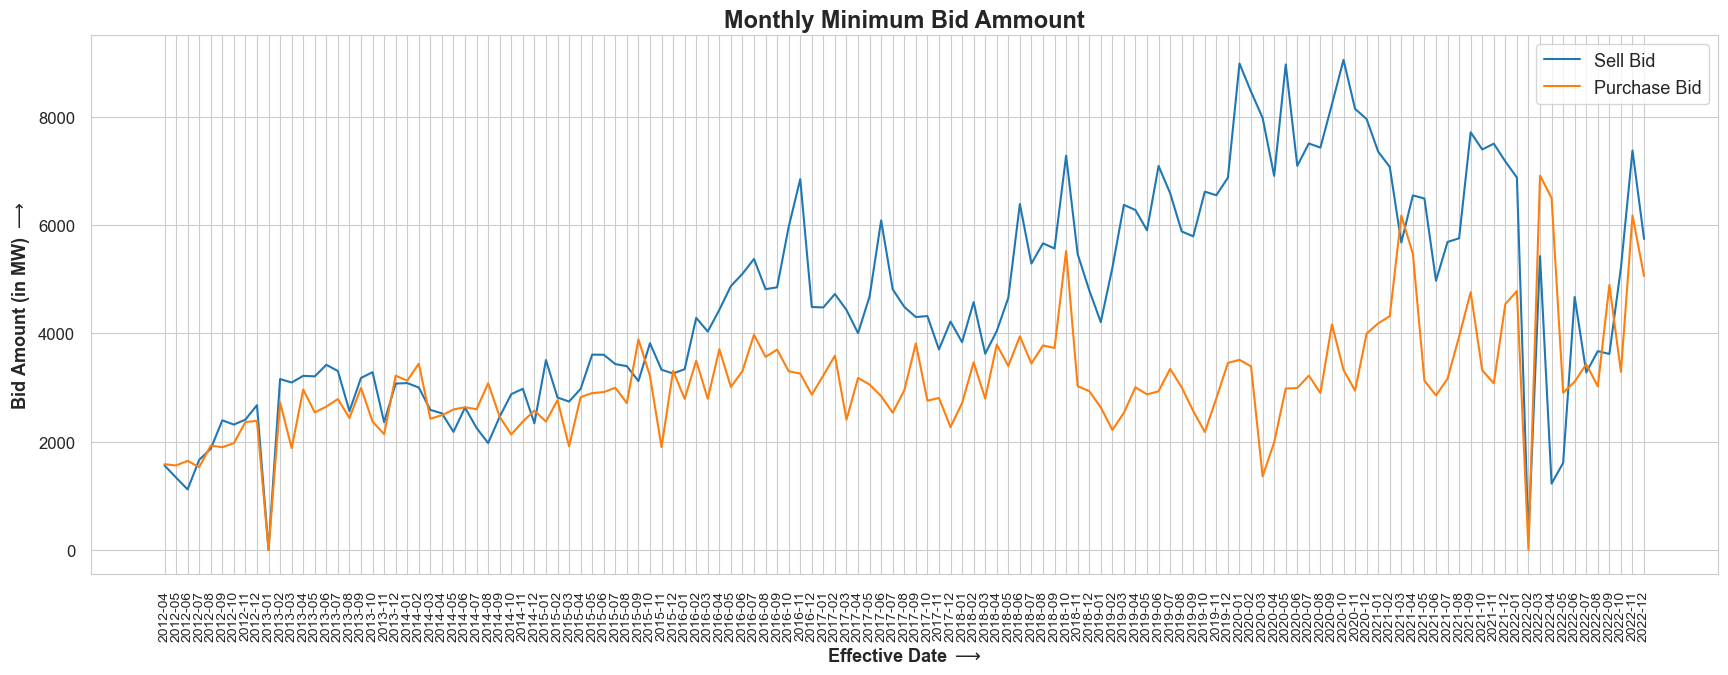

In [15]:
lineplot_1d(
    monthly_statistics_[[("SellBid", "min"), ("PurchaseBid", "min")]].values,
    xticks = list(map(lambda dt : f"{dt[0]}-{str(dt[1]).zfill(2)}", monthly_statistics_.index.values)),
    legends = ["Sell Bid", "Purchase Bid"],
    xlabel = "Effective Date $\longrightarrow$",
    ylabel = "Bid Amount (in MW) $\longrightarrow$",
    title = "Monthly Minimum Bid Ammount"
)

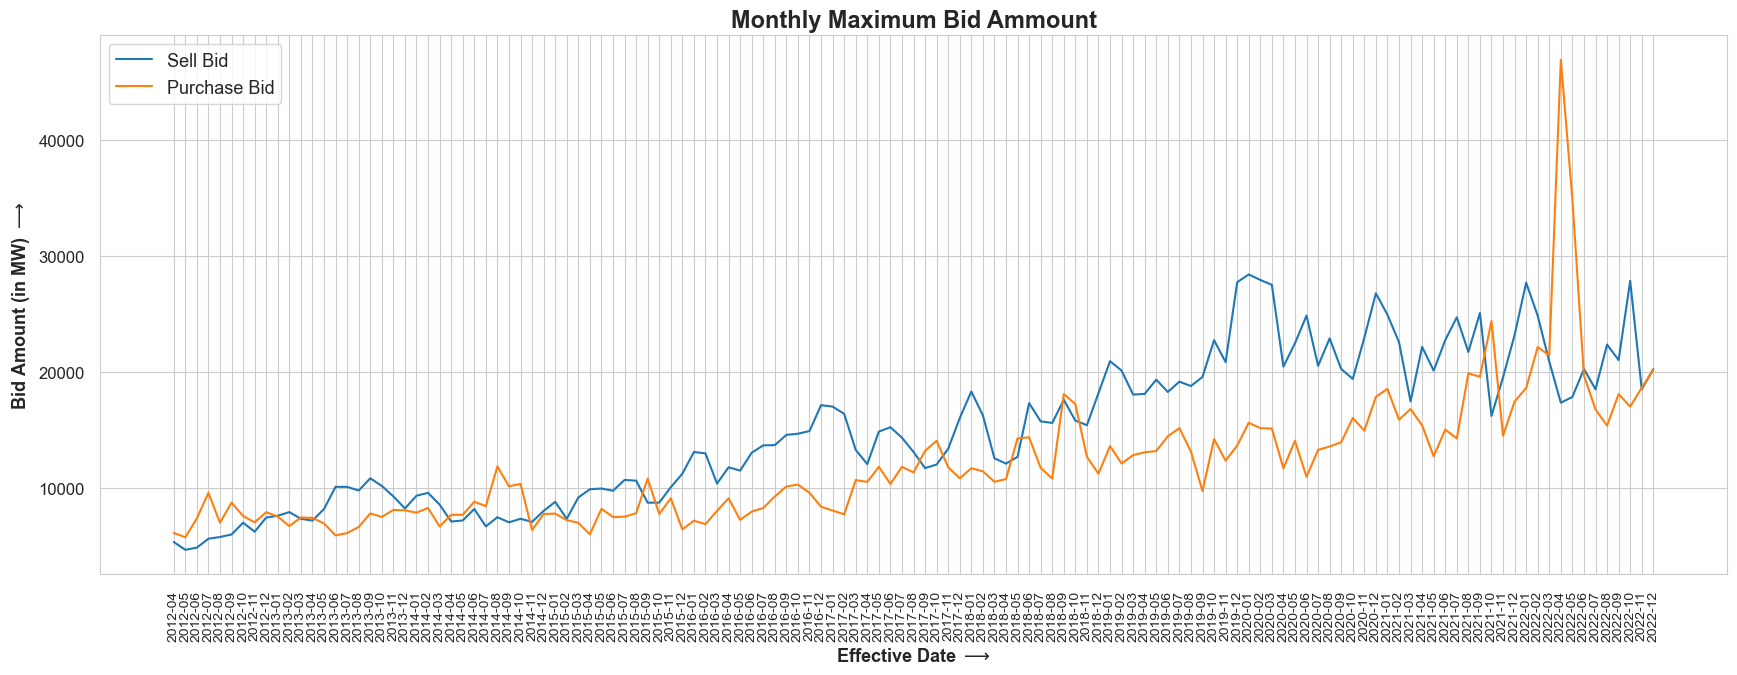

In [16]:
lineplot_1d(
    monthly_statistics_[[("SellBid", "max"), ("PurchaseBid", "max")]].values,
    xticks = list(map(lambda dt : f"{dt[0]}-{str(dt[1]).zfill(2)}", monthly_statistics_.index.values)),
    legends = ["Sell Bid", "Purchase Bid"],
    xlabel = "Effective Date $\longrightarrow$",
    ylabel = "Bid Amount (in MW) $\longrightarrow$",
    title = "Monthly Maximum Bid Ammount"
)

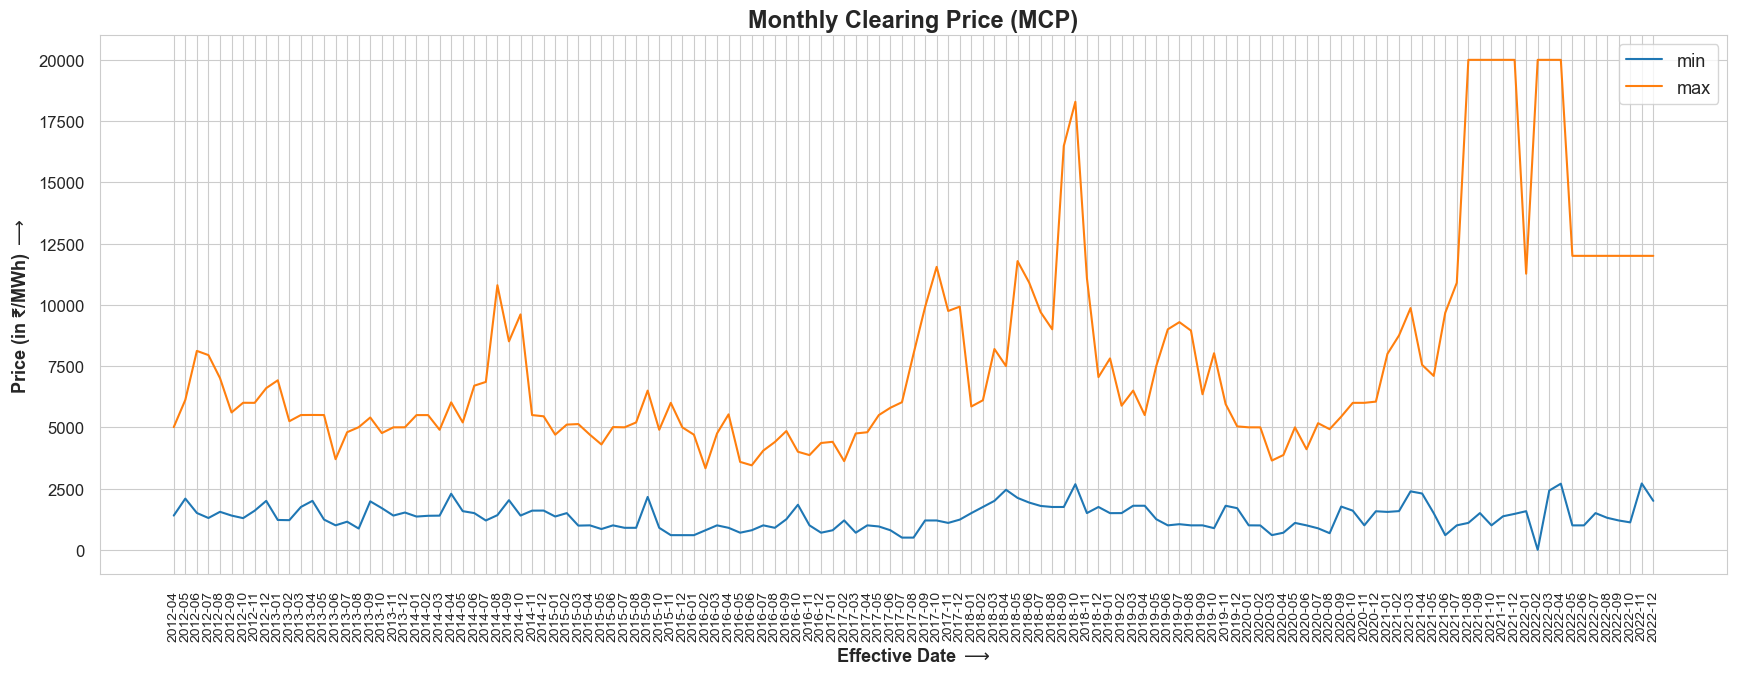

In [17]:
lineplot_1d(
    monthly_statistics_[[("MCP", "min"), ("MCP", "max")]].values,
    xticks = list(map(lambda dt : f"{dt[0]}-{str(dt[1]).zfill(2)}", monthly_statistics_.index.values)),
    legends = ["min", "max"],
    xlabel = "Effective Date $\longrightarrow$",
    ylabel = "Price (in ₹/MWh) $\longrightarrow$",
    title = "Monthly Clearing Price (MCP)"
)

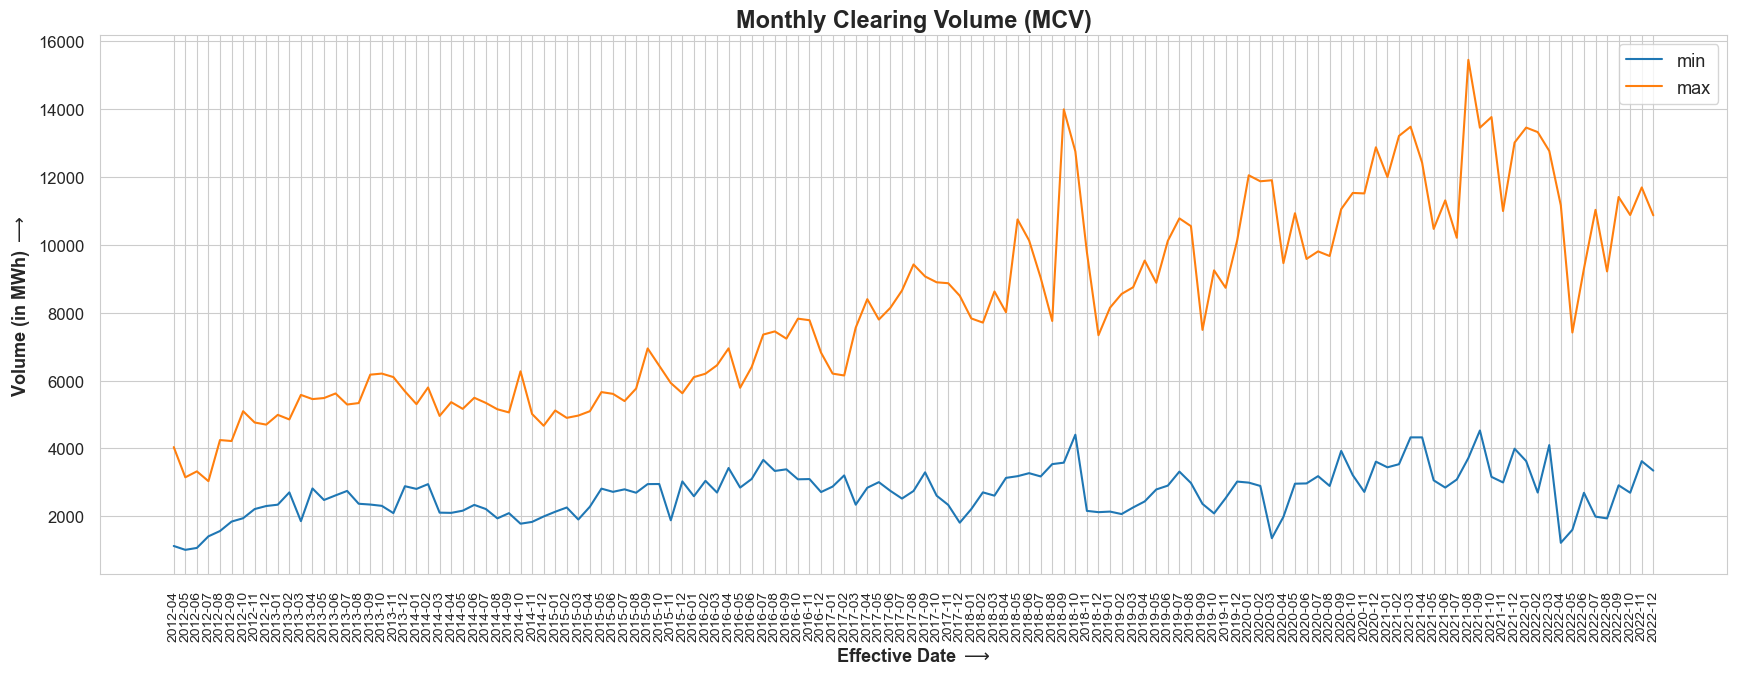

In [18]:
lineplot_1d(
    monthly_statistics_[[("MCV", "min"), ("MCV", "max")]].values,
    xticks = list(map(lambda dt : f"{dt[0]}-{str(dt[1]).zfill(2)}", monthly_statistics_.index.values)),
    legends = ["min", "max"],
    xlabel = "Effective Date $\longrightarrow$",
    ylabel = "Volume (in MWh) $\longrightarrow$",
    title = "Monthly Clearing Volume (MCV)"
)

### Creating `data` Variable

For small case approach, consider only ten continuous days of data and extract the `y` matrix as an `np.ndarray` for further processing. To keep memory at *minimum* also delete all table and data variables. 🚧 TODO create a `pkl` file to load and perform analysis.

In [16]:
START_DATE = dt.datetime(year = 2019, month = 4, day = 1)
FINAL_DATE = dt.datetime(year = 2022, month = 10, day = 31)

data = market_snapshot[(market_snapshot["EffectiveDate"] >= START_DATE) & (market_snapshot["EffectiveDate"] <= FINAL_DATE)]
data = data["scaled(MCP)"].values

# assert data integrity, and also check if all records are present
assert data.shape[0] % 96 == 0 # all records are present

In [17]:
del mcp_values_0, sc_mcp_values_0, mcp_values_1, sc_mcp_values_1

### Data Formatting for ML Model

Format and `.reshape()` the data to be passed directly into a ML model.

In [18]:
n_lookback = 3 * 96 # 🧪 look into 7 days past records
n_forecast = 2 * 96 # on t(-1) we want prediction for t(+1)

In [19]:
x_train, y_train = CreateSequence(data).create_univariate_series(
    n_lookback = n_lookback,
    n_forecast = n_forecast
)

# assert data shapes, which should always match
assert x_train.shape[1] == n_lookback
assert y_train.shape[1] == n_forecast

x_train.shape, y_train.shape

((125377, 288, 1), (125377, 192, 1))

In [27]:
# training_data_outfile = os.path.join(
#     PROCESSED_DATA,
#     f"xy_train_consolidated_{str(START_DATE.date())}_{str(FINAL_DATE.date())}_n_lookback_{n_lookback}_n_forecast_{n_forecast}.npy"
# )

# with open(training_data_outfile, "wb") as fileObj:
#     np.save(fileObj, x_train)
#     np.save(fileObj, y_train)

## Model Development

The model is developed and trained using *user-defined* functions available typically under **`src`**, which makes it easier to keep all the codes and functionalities same, and just change the model and input to suit the need and easily switch between R&D, testing and production environment.

In [34]:
# neural network parameters, parametric as much possible
ACTIVATION_FUNCTION = "relu"

# model tuning parameters
LR_START = 1e-3
LR_FINAL = 2e-4
NUM_EPOCHS = 3 # keeping small during r&d
BATCH_SIZE = 1024

# callback and model monitoring criteria
LR_FUNC = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.2, patience = 5, min_lr = LR_FINAL)
ES_FUNC = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 12, min_delta = 0.001, restore_best_weights = True)
TM_FUNC = tf.keras.callbacks.TerminateOnNaN()

# define the callbacks for model
callbacks = [
    LR_FUNC, # learning rate
    ES_FUNC, # early stopping of model training
    TM_FUNC  # terminate model training on null value
]

In [35]:
# https://ai.stackexchange.com/a/3162
# https://stackoverflow.com/a/59073430
# https://stackoverflow.com/a/58868383
# https://datascience.stackexchange.com/a/65079
# https://datascience.stackexchange.com/a/18049
# https://datascience.stackexchange.com/q/12964
# conf. paper (word cloud proj.) https://ieeexplore.ieee.org/document/9132839
# tensorflow layer not using cuDNN https://stackoverflow.com/q/68844792/6623589

model = BareLSTM(
    input_shape = (n_lookback, 1), # ⚠ for univariate shape is always `(-1, 1)`
    output_shape = n_forecast, # 💿 high network will throw resource error
    activation = ACTIVATION_FUNCTION
).get_2_layer_lstm(units = [64, 32])
model.summary(line_length = 127)

Model: "BareLSTM-1.0.0"
_______________________________________________________________________________________________________________________________
 Layer (type)                                            Output Shape                                      Param #             
 iLayer (LSTM)                                           (None, 288, 64)                                   16896               
                                                                                                                               
 HL-1 (LSTM)                                             (None, 32)                                        12416               
                                                                                                                               
 oLayer (Dense)                                          (None, 192)                                       6336                
                                                                                

In [36]:
trainer = base(model)
trainer.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = LR_START, amsgrad = True),
    loss = tf.keras.losses.MeanSquaredError(name = "loss"),
    metrics = [tf.keras.metrics.RootMeanSquaredError(name = "RMSE"), tf.keras.metrics.MeanAbsoluteError(name = "MAE")]
)

# get the history from `.train` method
history = trainer.train(x = x_train, y = y_train, num_epochs = NUM_EPOCHS, batch_size = BATCH_SIZE)

Epoch 1/3
117/117 [==============================] - 500s 4s/step - loss: 0.4068 - RMSE: 0.6378 - MAE: 0.4344 - val_loss: 0.0590 - val_RMSE: 0.2429 - val_MAE: 0.1669
Epoch 2/3
117/117 [==============================] - 526s 5s/step - loss: 0.0195 - RMSE: 0.1396 - MAE: 0.0917 - val_loss: 0.0482 - val_RMSE: 0.2195 - val_MAE: 0.1496
Epoch 3/3
117/117 [==============================] - 494s 4s/step - loss: 0.0157 - RMSE: 0.1254 - MAE: 0.0789 - val_loss: 0.0432 - val_RMSE: 0.2079 - val_MAE: 0.1432


In [39]:
# model.save(os.path.join(OUTPUT_DIR, "savedmodels", f"{str(dt.datetime.today().date())} {model.name}.h5"))

### Model Evaluation

In the below section, we evaluate the model performance based on various factors.

In [15]:
model = tf.keras.models.load_model(os.path.join(OUTPUT_DIR, "savedmodels", "2023-01-21 BareLSTM-1.0.0.h5"))
inverse_scaler = UnivariateRangedScaler(x_min = 0.10 * 1e3, x_max = 12.00 * 1e3, feature_range = (1, 2))

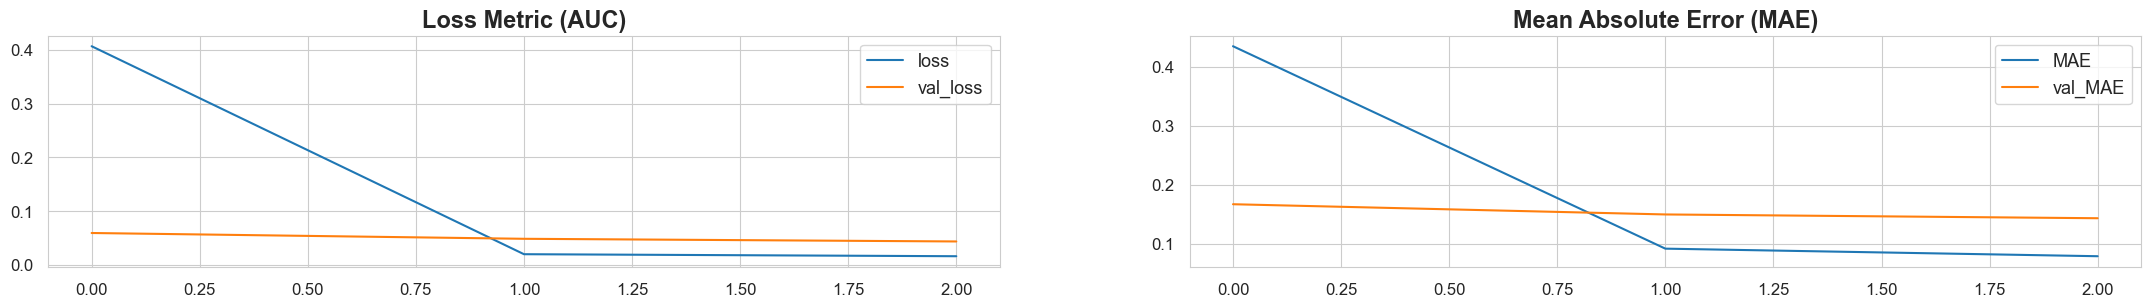

In [37]:
plt.figure(figsize = (27, 3))

plt.subplot(121)
plt.plot(history.history["loss"], label = "loss")
plt.plot(history.history["val_loss"], label = "val_loss")

plt.title("Loss Metric (AUC)")
plt.legend()

plt.subplot(122)
plt.plot(history.history["MAE"], label = "MAE")
plt.plot(history.history["val_MAE"], label = "val_MAE")

plt.title("Mean Absolute Error (MAE)")
plt.legend()

plt.savefig(os.path.join(OUTPUT_DIR, "images", f"{str(dt.datetime.today().date())} {model.name}.png"))

plt.show()

**Known Data Block(s)**

In [18]:
TEST_START_DAY = dt.datetime(year = 2022, month = 9, day = 24)
TEST_FINAL_DAY = dt.datetime(year = 2022, month = 9, day = 26)

PREDICTION_START_DAY = dt.datetime(year = 2022, month = 9, day = 27)
PREDICTION_FINAL_DAY = dt.datetime(year = 2022, month = 9, day = 28)

test_data = market_snapshot[(market_snapshot["EffectiveDate"] >= TEST_START_DAY) & (market_snapshot["EffectiveDate"] <= TEST_FINAL_DAY)]["scaled(MCP)"].values
y_actual_ = market_snapshot[(market_snapshot["EffectiveDate"] >= PREDICTION_START_DAY) & (market_snapshot["EffectiveDate"] <= PREDICTION_FINAL_DAY)]["scaled(MCP)"].values

In [21]:
y_predicted = model.predict(test_data.reshape(-1, n_lookback, 1))[0]

# calculate the mae and rmse loss for the model as:
print(f"""
Error Analysis Report
=====================
  Mean Absolute Error (MAE)      : {MAE(y_actual_, y_predicted):.5f}
  Root Mean Squared Error (RMSE) : {MSE(y_actual_, y_predicted, squared = False):.5f}
""")

1/1 [==============================] - 2s 2s/step

Error Analysis Report
  Mean Absolute Error (MAE)      : 0.13581
  Root Mean Squared Error (RMSE) : 0.19299



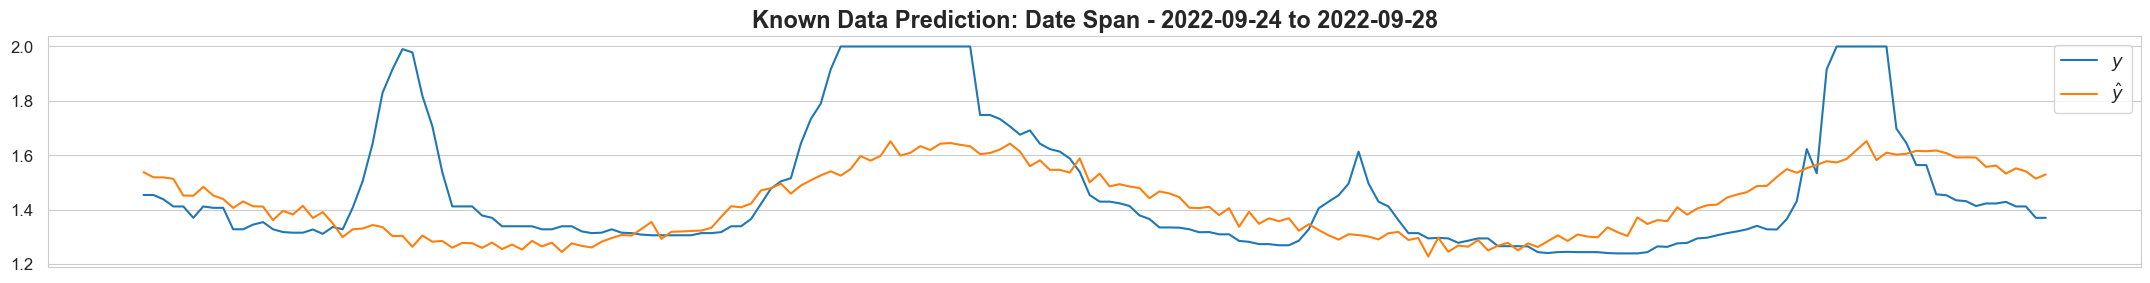

In [26]:
plt.figure(figsize = (27, 3))

plt.plot(y_actual_, label = "$y$")
plt.plot(y_predicted, label = "$\hat{y}$")

plt.xticks([]) # close for now
plt.title(f"Known Data Prediction: Date Span - {TEST_START_DAY.date()} to {PREDICTION_FINAL_DAY.date()}")
plt.legend()
plt.show()

**Unknown Data Block(s)**

In [27]:
TEST_START_DAY = dt.datetime(year = 2022, month = 11, day = 5)
TEST_FINAL_DAY = dt.datetime(year = 2022, month = 11, day = 7)

PREDICTION_START_DAY = dt.datetime(year = 2022, month = 11, day = 8)
PREDICTION_FINAL_DAY = dt.datetime(year = 2022, month = 11, day = 9)

test_data = market_snapshot[(market_snapshot["EffectiveDate"] >= TEST_START_DAY) & (market_snapshot["EffectiveDate"] <= TEST_FINAL_DAY)]["scaled(MCP)"].values
y_actual_ = market_snapshot[(market_snapshot["EffectiveDate"] >= PREDICTION_START_DAY) & (market_snapshot["EffectiveDate"] <= PREDICTION_FINAL_DAY)]["scaled(MCP)"].values

In [29]:
y_predicted = model.predict(test_data.reshape(-1, n_lookback, 1))[0]

# calculate the mae and rmse loss for the model as:
print(f"""
Error Analysis Report
=====================
  Mean Absolute Error (MAE)      : {MAE(y_actual_, y_predicted):.5f}
  Root Mean Squared Error (RMSE) : {MSE(y_actual_, y_predicted, squared = False):.5f}
""")

1/1 [==============================] - 0s 444ms/step

Error Analysis Report
  Mean Absolute Error (MAE)      : 0.09627
  Root Mean Squared Error (RMSE) : 0.12307



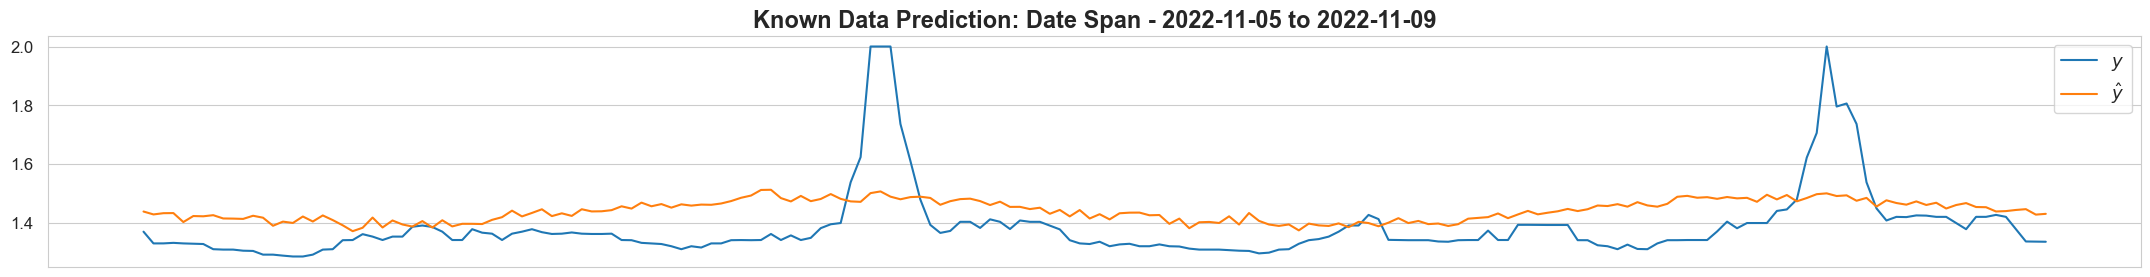

In [30]:
plt.figure(figsize = (27, 3))

plt.plot(y_actual_, label = "$y$")
plt.plot(y_predicted, label = "$\hat{y}$")

plt.xticks([]) # close for now
plt.title(f"Known Data Prediction: Date Span - {TEST_START_DAY.date()} to {PREDICTION_FINAL_DAY.date()}")
plt.legend()
plt.show()